In [1]:
# Define the gpu  on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from evaluation import testing
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [3]:
# Import the test file
df_test = pd.read_csv("sample-evaluation-annotation.tsv", sep="\t")
df_test.head(2)

,id,text_id,url,domain,y_pred,text,text_length,translation,y_true,comment
0,403,CLASSLA-web.mk.40729,https://okno.mk/node/63839,okno.mk,Opinion/Argumentation,Од будалетинка до диктаторче ...,285,From a fool to dictator Gruevski was a reforme...,Opinion/Argumentation,Or News
1,2249,CLASSLA-web.hr.225355,http://www.gkc-petrinja.hr/biblosam/preglednas...,gkc-petrinja.hr,Prose/Lyrical,U namjeri da se prisjeti tko je zapravo i što ...,98,In order to remember who he really was and wha...,Prose/Lyrical,NaN


In [4]:
df_test.describe(include="all")

,id,text_id,url,domain,y_pred,text,text_length,translation,y_true,comment
count,270.000000,270,270,270,270,270,270.000000,270,270,39
unique,NaN,270,270,226,9,270,NaN,270,10,19
top,NaN,CLASSLA-web.mk.40729,https://okno.mk/node/63839,besedilo.si,Opinion/Argumentation,Од будалетинка до диктаторче ...,NaN,From a fool to dictator Gruevski was a reforme...,Promotion,Not a coherent text
freq,NaN,1,1,5,30,1,NaN,1,40,14
mean,52800.066667,NaN,NaN,NaN,NaN,NaN,213.051852,NaN,NaN,NaN
std,28044.579222,NaN,NaN,NaN,NaN,NaN,117.241518,NaN,NaN,NaN
min,403.000000,NaN,NaN,NaN,NaN,NaN,64.000000,NaN,NaN,NaN
25%,29918.000000,NaN,NaN,NaN,NaN,NaN,117.250000,NaN,NaN,NaN
50%,53315.500000,NaN,NaN,NaN,NaN,NaN,182.500000,NaN,NaN,NaN
75%,77339.250000,NaN,NaN,NaN,NaN,NaN,277.750000,NaN,NaN,NaN


In [5]:
# Separate the test file into three dfs, based on the language of the corpora
df_test["corpus"] = df_test["text_id"].apply(lambda x:x.split(".")[1])

df_test.corpus.value_counts()

corpus
mk    90
hr    90
sl    90
Name: count, dtype: int64

In [6]:
mk_df = df_test[df_test["corpus"] == "mk"]
hr_df = df_test[df_test["corpus"] == "hr"]
sl_df = df_test[df_test["corpus"] == "sl"]

corpora = [mk_df, hr_df, sl_df]

mk_df.head(3)

,id,text_id,url,domain,y_pred,text,text_length,translation,y_true,comment,corpus
0,403,CLASSLA-web.mk.40729,https://okno.mk/node/63839,okno.mk,Opinion/Argumentation,Од будалетинка до диктаторче ...,285,From a fool to dictator Gruevski was a reforme...,Opinion/Argumentation,Or News,mk
4,3836,CLASSLA-web.mk.378842,http://arhiva.sdsm.org.mk/print.aspx?eventId=1...,arhiva.sdsm.org.mk,Other,Да изготвиме и потпишеме декларација со која н...,217,To prepare and sign a declaration that will st...,Opinion/Argumentation,NaN,mk
5,4330,CLASSLA-web.mk.425293,https://www.brif.mk/namalena-pobaruvachkata-za...,brif.mk,News,"Намалена побарувачката за станови, укажуваат а...",152,"Demand for housing decreased, real estate agen...",News,NaN,mk


In [7]:
df_test.columns

Index(['id', 'text_id', 'url', 'domain', 'y_pred', 'text', 'text_length',
       'translation', 'y_true', 'comment', 'corpus'],
      dtype='object')

In [8]:
# Analyze number of problematic texts
for corpus in corpora:
    print("Corpus: {}\n".format(corpus["corpus"].to_list()[0]))
    print(corpus["y_true"].value_counts().to_markdown())
    print("\n")
    print(corpus["y_true"].value_counts(normalize="True").to_markdown())
    print("\n--------------------------------------\n\n")

Corpus: mk

| y_true                  |   count |
|:------------------------|--------:|
| Opinion/Argumentation   |      15 |
| News                    |      11 |
| Promotion               |      11 |
| Legal                   |      10 |
| Prose/Lyrical           |      10 |
| Forum                   |       9 |
| Instruction             |       9 |
| Problematic             |       7 |
| Information/Explanation |       7 |
| Other                   |       1 |


| y_true                  |   proportion |
|:------------------------|-------------:|
| Opinion/Argumentation   |    0.166667  |
| News                    |    0.122222  |
| Promotion               |    0.122222  |
| Legal                   |    0.111111  |
| Prose/Lyrical           |    0.111111  |
| Forum                   |    0.1       |
| Instruction             |    0.1       |
| Problematic             |    0.0777778 |
| Information/Explanation |    0.0777778 |
| Other                   |    0.0111111 |

-------------

In [9]:
# Filter out "Other" instances and "Problematic" instances so that we will do analysis on clear examples only
df_test_clean = df_test[df_test["y_pred"] != "Other"]
df_test_clean = df_test_clean[df_test_clean["y_true"] != "Problematic"]

df_test_clean.describe(include="all")

,id,text_id,url,domain,y_pred,text,text_length,translation,y_true,comment,corpus
count,225.000000,225,225,225,225,225,225.000000,225,225,13,225
unique,NaN,225,225,191,8,225,NaN,225,8,11,3
top,NaN,CLASSLA-web.mk.40729,https://okno.mk/node/63839,forum.carclub.mk,Opinion/Argumentation,Од будалетинка до диктаторче ...,NaN,From a fool to dictator Gruevski was a reforme...,Promotion,Or News,mk
freq,NaN,1,1,5,30,1,NaN,1,32,2,76
mean,54420.755556,NaN,NaN,NaN,NaN,NaN,213.044444,NaN,NaN,NaN,NaN
std,27553.277543,NaN,NaN,NaN,NaN,NaN,115.299562,NaN,NaN,NaN,NaN
min,403.000000,NaN,NaN,NaN,NaN,NaN,64.000000,NaN,NaN,NaN,NaN
25%,32797.000000,NaN,NaN,NaN,NaN,NaN,121.000000,NaN,NaN,NaN,NaN
50%,55640.000000,NaN,NaN,NaN,NaN,NaN,187.000000,NaN,NaN,NaN,NaN
75%,78461.000000,NaN,NaN,NaN,NaN,NaN,270.000000,NaN,NaN,NaN,NaN


In [10]:
# Create clean subcorpora
mk_df_clean = df_test_clean[df_test_clean["corpus"] == "mk"]
hr_df_clean = df_test_clean[df_test_clean["corpus"] == "hr"]
sl_df_clean = df_test_clean[df_test_clean["corpus"] == "sl"]

corpora_clean = [mk_df_clean, hr_df_clean, sl_df_clean]

mk_df_clean.head(3)

,id,text_id,url,domain,y_pred,text,text_length,translation,y_true,comment,corpus
0,403,CLASSLA-web.mk.40729,https://okno.mk/node/63839,okno.mk,Opinion/Argumentation,Од будалетинка до диктаторче ...,285,From a fool to dictator Gruevski was a reforme...,Opinion/Argumentation,Or News,mk
5,4330,CLASSLA-web.mk.425293,https://www.brif.mk/namalena-pobaruvachkata-za...,brif.mk,News,"Намалена побарувачката за станови, укажуваат а...",152,"Demand for housing decreased, real estate agen...",News,NaN,mk
11,6270,CLASSLA-web.mk.609997,http://kiselavoda.gov.mk/index.php/naslovna/no...,kiselavoda.gov.mk,Legal,-Усвојување на Записникот од 27-та пленарна се...,131,-Uagement of the minutes of the 27th plenary s...,Legal,NaN,mk


In [11]:
# Analyze y_pred labels in cleaned corpora
for corpus in corpora_clean:
    print("Corpus: {}\n".format(corpus["corpus"].to_list()[0]))
    print(corpus["y_pred"].value_counts().to_markdown())
    print("\n")
    print(corpus["y_pred"].value_counts(normalize="True").to_markdown())
    print("\n--------------------------------------\n\n")

Corpus: mk

| y_pred                  |   count |
|:------------------------|--------:|
| Opinion/Argumentation   |      10 |
| Legal                   |      10 |
| Information/Explanation |      10 |
| Prose/Lyrical           |      10 |
| News                    |       9 |
| Promotion               |       9 |
| Forum                   |       9 |
| Instruction             |       9 |


| y_pred                  |   proportion |
|:------------------------|-------------:|
| Opinion/Argumentation   |     0.131579 |
| Legal                   |     0.131579 |
| Information/Explanation |     0.131579 |
| Prose/Lyrical           |     0.131579 |
| News                    |     0.118421 |
| Promotion               |     0.118421 |
| Forum                   |     0.118421 |
| Instruction             |     0.118421 |

--------------------------------------


Corpus: hr

| y_pred                  |   count |
|:------------------------|--------:|
| Prose/Lyrical           |      10 |
| News  

Corpus: CLASSLA.web-mk

Macro f1: 0.933, Micro f1: 0.934
Accuracy: 0.934


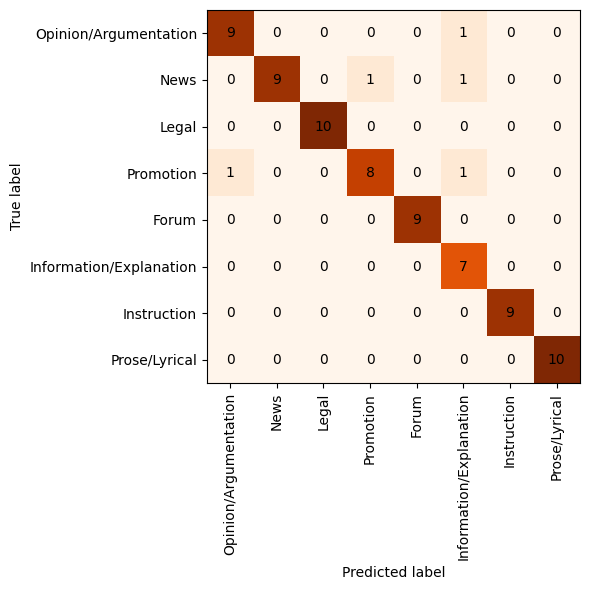

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Opinion/Argumentation   |    1        | 1        |   1        |  9        |
| News                    |    0.7      | 1        |   0.823529 |  7        |
| Legal                   |    1        | 1        |   1        |  9        |
| Promotion               |    1        | 1        |   1        | 10        |
| Forum                   |    1        | 0.818182 |   0.9      | 11        |
| Information/Explanation |    0.9      | 0.9      |   0.9      | 10        |
| Instruction             |    0.888889 | 0.8      |   0.842105 | 10        |
| Prose/Lyrical           |    1        | 1        |   1        | 10        |
| accuracy                |    0.934211 | 0.934211 |   0.934211 |  0.934211 |
| macro avg               |    0.936111 | 0.939773 |   0.933204 | 76        |
| weighted avg            |    0.944591 | 0.934211 |   0.935339 

<Figure size 640x480 with 0 Axes>

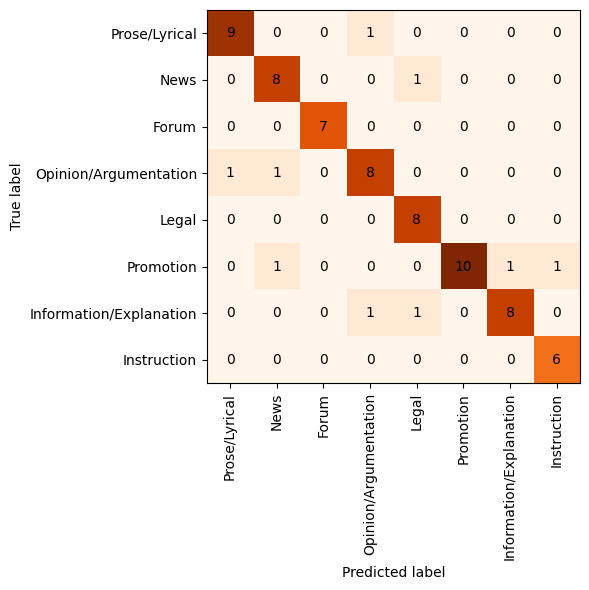

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Prose/Lyrical           |    1        | 1        |   1        |  7        |
| News                    |    0.888889 | 0.8      |   0.842105 | 10        |
| Forum                   |    0.857143 | 1        |   0.923077 |  6        |
| Opinion/Argumentation   |    0.8      | 1        |   0.888889 |  8        |
| Legal                   |    0.8      | 0.888889 |   0.842105 |  9        |
| Promotion               |    0.8      | 0.8      |   0.8      | 10        |
| Information/Explanation |    1        | 0.769231 |   0.869565 | 13        |
| Instruction             |    0.9      | 0.9      |   0.9      | 10        |
| accuracy                |    0.876712 | 0.876712 |   0.876712 |  0.876712 |
| macro avg               |    0.880754 | 0.894765 |   0.883218 | 73        |
| weighted avg            |    0.885366 | 0.876712 |   0.876081 

<Figure size 640x480 with 0 Axes>

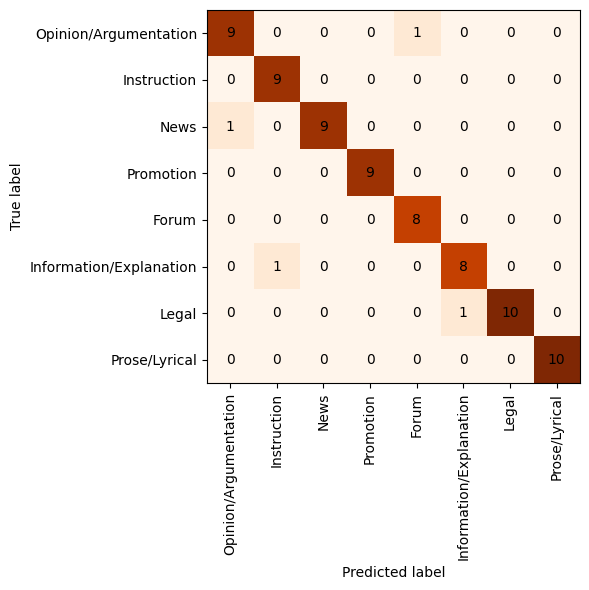

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Opinion/Argumentation   |    0.888889 | 1        |   0.941176 |  8        |
| Instruction             |    0.888889 | 0.888889 |   0.888889 |  9        |
| News                    |    0.9      | 1        |   0.947368 |  9        |
| Promotion               |    1        | 0.909091 |   0.952381 | 11        |
| Forum                   |    1        | 0.9      |   0.947368 | 10        |
| Information/Explanation |    0.9      | 0.9      |   0.9      | 10        |
| Legal                   |    1        | 1        |   1        |  9        |
| Prose/Lyrical           |    1        | 1        |   1        | 10        |
| accuracy                |    0.947368 | 0.947368 |   0.947368 |  0.947368 |
| macro avg               |    0.947222 | 0.949747 |   0.947148 | 76        |
| weighted avg            |    0.950146 | 0.947368 |   0.947442 

<Figure size 640x480 with 0 Axes>

In [12]:
all_results = {}

for corpus in corpora_clean:
    cur_corpus = "CLASSLA.web-{}".format(corpus["corpus"].to_list()[0])
    y_pred = corpus["y_pred"].to_list()
    y_true = corpus["y_true"].to_list()
    labels = list(corpus["y_true"].unique())

    print("Corpus: {}\n".format(cur_corpus))

    results = testing(y_true, y_pred, labels)
    all_results[cur_corpus] = results

In [13]:
en_ginco_all_results = {}
x_genre_all_results = {}
x_genre_en_all_results = {}
x_genre_sl_all_results = {}
x_genre_ftd_all_results = {}
x_genre_core_all_results = {}

In [14]:
for model in ['logistic-regression','svc', "X-GENRE", 'gpt-3.5-turbo-corrected', 'gpt4-corrected']:
    print(model)
    result = test_splits(model)
    en_ginco_all_results[model] = result["en-ginco"]
    x_genre_all_results[model] = result["x-genre"]
    x_genre_en_all_results[model] = result["x-genre-en"]
    x_genre_sl_all_results[model] = result["x-genre-sl"]
    x_genre_ftd_all_results[model] = result["x-genre-ftd"]
    x_genre_core_all_results[model] = result["x-genre-core"]

en_ginco_res_df = pd.DataFrame(en_ginco_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
x_genre_res_df = pd.DataFrame(x_genre_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
x_genre_en_res_df = pd.DataFrame(x_genre_en_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
x_genre_sl_res_df = pd.DataFrame(x_genre_sl_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
x_genre_ftd_res_df = pd.DataFrame(x_genre_ftd_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)
x_genre_core_res_df = pd.DataFrame(x_genre_core_all_results).T[["micro F1", "macro F1", "accuracy"]].sort_values("macro F1", ascending=False).round(2)



logistic-regression


NameError: name 'test_splits' is not defined

In [ ]:
print("EN-GINCO\n")
print(en_ginco_res_df.to_markdown())
print("\nX-GENRE (all)\n")
print(x_genre_res_df.to_markdown())

EN-GINCO

|                         |   micro F1 |   macro F1 |   accuracy |
|:------------------------|-----------:|-----------:|-----------:|
| X-GENRE                 |       0.68 |       0.69 |       0.68 |
| gpt4-corrected          |       0.65 |       0.55 |       0.65 |
| gpt-3.5-turbo-corrected |       0.63 |       0.53 |       0.63 |
| svc                     |       0.49 |       0.51 |       0.49 |
| logistic-regression     |       0.49 |       0.47 |       0.49 |

X-GENRE (all)

|                         |   micro F1 |   macro F1 |   accuracy |
|:------------------------|-----------:|-----------:|-----------:|
| X-GENRE                 |       0.8  |       0.79 |       0.8  |
| logistic-regression     |       0.65 |       0.67 |       0.65 |
| gpt4-corrected          |       0.7  |       0.66 |       0.7  |
| svc                     |       0.66 |       0.66 |       0.66 |
| gpt-3.5-turbo-corrected |       0.65 |       0.63 |       0.65 |
